In [39]:
import os
import cv2
import numpy as np
import tensorflow.compat.v1 as tf

import matplotlib.pyplot as plt

In [40]:
tf.disable_eager_execution()

In [41]:
# Helper functions 
def upsample(input_tensor, num_filters, kernel_size, apply_dropout= False):
    # init. weights from a random normal distribution
    weight_init = tf.random_normal_initializer(0., 0.02)

    # Transposed convolution -> batch_norm -> relu
    result = tf.layers.conv2d_transpose(inputs= input_tensor,
                                        filters = num_filters,
                                        strides = 2,
                                        kernel_size = kernel_size,
                                        use_bias = False,
                                        kernel_initializer = weight_init,
                                        padding = "SAME",
                                        
                                        )
    result = tf.layers.batch_normalization(result, training = True, axis = -1)
    if apply_dropout:
        result = tf.nn.dropout(result, keep_prob=0.5)

    result = tf.nn.relu(result)

    return result


def downsample(input_tensor, num_filters, kernel_size, apply_batchnorm):
    # init. from a random normal distribution
    weight_init = tf.random_normal_initializer(0., 0.02)

    # Conv2D -> BatchNorm -> Leaky Relu
    result = tf.layers.conv2d(input_tensor,
                        filters = num_filters,
                        padding = "SAME",
                        kernel_size = kernel_size,
                        strides =2,
                        kernel_initializer = weight_init,
                        use_bias = False,
                        )
    if apply_batchnorm:
        result = tf.layers.batch_normalization(result, training = True, axis = -1)

    result = tf.nn.leaky_relu(result, alpha = 0.2)
    return result

In [42]:
def generator(source_img, reuse = None):
    with tf.variable_scope("generator_model", reuse= reuse):

        # Downsampling block
        down_1 = downsample(input_tensor= source_img,
                    num_filters = 64,
                    kernel_size= 4,
                    apply_batchnorm= True)
        
        down_2 = downsample(input_tensor= down_1,
                    num_filters = 128,
                    kernel_size= 4,
                    apply_batchnorm= True)
        
        down_3 = downsample(input_tensor= down_2,
                    num_filters = 256,
                    kernel_size= 4,
                    apply_batchnorm= True)
        
        down_4 = downsample(input_tensor= down_3,
                    num_filters = 512,
                    kernel_size= 4,
                    apply_batchnorm= True)
        
        down_5 = downsample(input_tensor= down_4,
                    num_filters = 512,
                    kernel_size= 4,
                    apply_batchnorm= True)
        
        down_6 = downsample(input_tensor= down_5,
                    num_filters = 512,
                    kernel_size= 4,
                    apply_batchnorm= True)
        
        down_7 = downsample(input_tensor= down_6,
                    num_filters = 512,
                    kernel_size= 4,
                    apply_batchnorm= True)
        
        down_8 = downsample(input_tensor= down_7,
                    num_filters = 512,
                    kernel_size= 4,
                    apply_batchnorm= True)
        
        # Upsampling Block
        up_1 = upsample(input_tensor = down_8,
                        num_filters = 512,
                        kernel_size = 4,
                        apply_dropout = True)
        up_1 = tf.concat([up_1, down_7], axis = 3)

        up_2 =  upsample(input_tensor = up_1,
                        num_filters = 512,
                        kernel_size = 4,
                        apply_dropout = True)
        up_2 = tf.concat([up_2, down_6], axis = 3)

        up_3 =  upsample(input_tensor = up_2,
                        num_filters = 512,
                        kernel_size = 4,
                        apply_dropout = True)
        up_3 = tf.concat([up_3, down_5], axis = 3)

        up_4 =  upsample(input_tensor = up_3,
                        num_filters = 512,
                        kernel_size = 4)
        up_4 = tf.concat([up_4, down_4], axis = 3)

        up_5 =  upsample(input_tensor = up_4,
                        num_filters = 256,
                        kernel_size = 4)
        up_5 = tf.concat([up_5, down_3], axis = 3)


        up_6 =  upsample(input_tensor = up_5,
                        num_filters = 128,
                        kernel_size = 4)
        up_6 = tf.concat([up_6, down_2], axis = 3)

        up_7 =  upsample(input_tensor = up_6,
                        num_filters = 64,
                        kernel_size = 4)
        up_7 = tf.concat([up_7, down_1], axis = 3)


        # Last output image
        random_normal_init = tf.random_normal_initializer(0., 0.02)
        output_image = tf.layers.conv2d_transpose(inputs= up_7,
                                            filters = 3,
                                            strides = 2,
                                            kernel_size = 4,
                                            padding = "SAME",
                                            kernel_initializer = random_normal_init,
                                            activation = "tanh")
        
        return output_image

In [43]:
tf.reset_default_graph()

# Source image placeholder
X = tf.placeholder(tf.float32, shape = [None, image_height, image_width, image_channels])

with tf.name_scope("Generator") as scope:
    gen_output = generator(source_img = X)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/legacy_tf_layers/convolutional.py:414: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  warnings.warn('`tf.layers.conv2d` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/legacy_tf_layers/normalization.py:308: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  '`tf.layers.batch_normalizat

In [70]:
# Paths
saver_path = "/content/drive/MyDrive/pix2pix/models/model"
test_image_path = "/content/drive/MyDrive/pix2pix/test_images/3.jpg"

In [71]:
def preprocess_image(image_path):
    """
    Input: Image path
    returns: Source image, nomalised source image, target image
    """
    BGR_image = cv2.imread(image_path)
    # converting the BGR image into a RGB image
    RGB_image = cv2.cvtColor(BGR_image, cv2.COLOR_BGR2RGB)
    # separating source and target image
    source_image, target_image = RGB_image[:, 0:600, :], RGB_image[:, 600:1200, :]
    # resizing the RGB image to (256, 256)
    source_resized_image = cv2.resize(source_image,
                                    (256, 256),
                                    interpolation = cv2.INTER_NEAREST)
    target_resized_image = cv2.resize(target_image,
                                    (256, 256),
                                    interpolation = cv2.INTER_NEAREST)
    # normalising both of the images so that all the pixel values are in between [-1, +1]
    source_nomalized_image = ((source_resized_image / 127.5) - 1.0).reshape(1, 256, 256, 3)
    target_normalized_image = (target_resized_image / 127.5) - 1.0
    
    return source_resized_image, source_nomalized_image, target_normalized_image

In [72]:
def plot(src_image, gen_image, trg_image):
    f, axarr = plt.subplots(1,3,  figsize=(14, 14))
 
    axarr[0].imshow(src_image);
    axarr[0].set_xlabel('Source Map')
 
    axarr[1].imshow(gen_image);
    axarr[1].set_xlabel('Predicted satelite Map')
 
 
    axarr[2].imshow(trg_image);
    axarr[2].set_xlabel('Target satelite Map')
 
    plt.show()

In [73]:
source_image, preprocessed_source, target_image = preprocess_image(image_path = test_image_path)

INFO:tensorflow:Restoring parameters from /content/drive/MyDrive/pix2pix/models/model


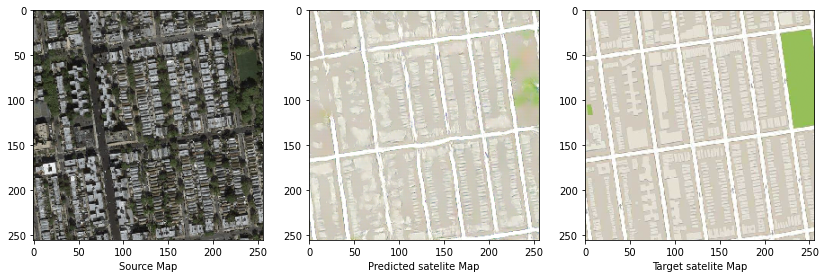

In [74]:
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    # restoring the saved model
    saver.restore(sess, save_path=saver_path)
    predicted_satelite_map = sess.run(gen_output,
                                      feed_dict=
                                      {X : preprocessed_source}).reshape(256, 256, 3)
    plot(src_image = source_image,
         gen_image = predicted_satelite_map,
         trg_image = target_image)